In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("..")

import torch
import wandb
import torchvision
import torchmetrics
from tqdm.notebook import tqdm
from src.utils.metrics import metrics, Metrics
from src.data.mri import MRIDataModule
from src.data.covidx import COVIDXDataModule
from src.utils.evaluation import WeightsandBiasEval
from src.models.imageclassifier import ImageClassifier

In [2]:
ENTITY = "24FS_I4DS27"
PROJECT = "baselines"
NUM_WORKERS = 0

BATCH_SIZE = 1 # DO NOT CHANGE
OUTPUT_SIZE = 1 # DO NOT CHANGE

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224), antialias=True),
    ]
)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
# Download models if not present
models = os.listdir("models")
models = [model for model in models if os.path.isdir(f"models/{model}")]
if len(models) != 22:
    evaluator = WeightsandBiasEval(entity_project_name=f"{ENTITY}/{PROJECT}")
    best_models = evaluator.get_best_models()

    for idx, metadata in tqdm(best_models.iterrows(), desc="Model - Dataset Pair", position=0, total=len(best_models)):
        print(f"\n---\nPair: {idx} - Model: {metadata.model} - Dataset: {metadata.dataset}")
        model_artifact = wandb.Api().artifact(f"{ENTITY}/{PROJECT}/model-{metadata.id}:best", type="model")
        model_path = model_artifact.file(root=f"models/{metadata.model}-{metadata.dataset}/")

In [4]:
def get_dataloader(dataset: str):
    if dataset == "covidx_data":
        return COVIDXDataModule(
            path="data/raw/COVIDX-CXR4",
            transform=transform,
            num_workers=NUM_WORKERS,
            batch_size=BATCH_SIZE,
            train_sample_size=0.05,
            train_shuffle=True,
        ).setup()
    elif dataset == "mri_data":
        return MRIDataModule(
            path="data/raw/Brain-Tumor-MRI",
            path_processed="data/processed/Brain-Tumor-MRI",
            transform=transform,
            num_workers=NUM_WORKERS,
            batch_size=BATCH_SIZE,
            train_shuffle=True,
        ).setup()
    else:
        raise ValueError("Invalid dataset")

def get_model(modelname: str, dataset: str):
    return ImageClassifier.load_from_checkpoint(
        checkpoint_path=f"models/{modelname}-{dataset}/model.ckpt",
        modelname=modelname,
        output_size=OUTPUT_SIZE,
        p_dropout_classifier=0.0,
        lr=0.0,
        weight_decay=0.0,
    )

In [5]:
desired_fooling_rate = 0.8
num_images = 30

for model in tqdm(models, desc="Model", position=0, total=len(models)):
    modelname, dataset = model.split("-")
    print(f"\n---\nModel: {modelname} - Dataset: {dataset}")

    datamodule = get_dataloader(dataset)
    model = get_model(modelname, dataset)
    model.freeze()
    model.eval()
    model.to(device)

    bce_f = torch.nn.BCELoss().to(device)
    norm_f = lambda x: torch.functional.norm(input=x, p=2)
    loss_bce_inv_f = lambda y_pred, y_adv: 1 / (bce_f(y_pred, y_adv)+1e-6)
    
    v = torch.zeros((1, 3, 224, 224), device=device, requires_grad=False)

    fooling_rate = 0.0
    epoch = 0

    # iterate, till the fooling rate is reached
    while fooling_rate < desired_fooling_rate:
        epoch += 1
        print(f"Starting epoch {epoch}...")

        # iterate over images
        n_image = 0
        for batch in tqdm(datamodule.train_dataloader(), desc="Image", position=1, total=num_images):
            
            # break on image limit
            if n_image == num_images:
                break
            
            # get image and label and move to device
            image, label = batch
            image, label = image.to(device), label.to(device)

            # initialize temporary adversarial perturbation
            v_temp = torch.zeros((1, 3, 224, 224), device=device, requires_grad=True)
            optimizer = torch.optim.Adam([v_temp], lr=0.1)

            # iterate till the image is fooled or limit
            for _ in range(10):

                # check if the image is fooled, if so, break
                with torch.no_grad():
                    x_adv = image + v + v_temp
                    x_adv = torch.clamp(x_adv, 0, 255)
                        
                    y_pred = model(image.round()).sigmoid()
                    y_adv = model(x_adv.round()).sigmoid()
                    #print(f"Prediction: {y_pred.item()}, Adversarial: {y_adv.item()}")

                    if y_pred.round() != y_adv.round():
                        v = v + v_temp
                        break

                # if the image is not fooled, update the adversarial perturbation   
                optimizer.zero_grad()

                x_adv = image + v + v_temp
                x_adv = torch.clamp(x_adv, 0, 255)

                y_pred = model(image).sigmoid()
                y_adv = model(x_adv).sigmoid()

                loss = loss_bce_inv_f(y_pred, y_adv) #+ 0.00001 * norm_f(v + v_temp) +
                #print(f"Loss: {loss}, Norm: {0.001 * norm_f(v + v_temp)}, InvBCE: {loss_bce_inv_f(y_pred, y_adv)}")

                loss.backward()
                #v.grad = torch.sign(v.grad)
                optimizer.step()

            n_image += 1

        # calculate fooling rate
        n_image = 0
        fooling_rate = 0
        for batch in tqdm(datamodule.train_dataloader(), desc="Image", position=1, total=num_images):
            if n_image == num_images:
                break

            image, label = batch
            image, label = image.to(device), label.to(device)

            x_adv = image + v
            x_adv = torch.clamp(x_adv, 0, 255)

            y_pred = model(image.round()).sigmoid()
            y_adv = model(x_adv.round()).sigmoid()

            if y_pred.round() != y_adv.round():
                fooling_rate += 1

            n_image += 1

        fooling_rate = fooling_rate / num_images
        print(f"Fooling rate: {fooling_rate}")

    break


Model:   0%|          | 0/22 [00:00<?, ?it/s]


---
Model: efficientnet_v2_l - Dataset: covidx_data
Starting epoch 1...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.13333333333333333
Starting epoch 2...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.06666666666666667
Starting epoch 3...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.1
Starting epoch 4...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.3
Starting epoch 5...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.43333333333333335
Starting epoch 6...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.5333333333333333
Starting epoch 7...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.5666666666666667
Starting epoch 8...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.4666666666666667
Starting epoch 9...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.5333333333333333
Starting epoch 10...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.5666666666666667
Starting epoch 11...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.6
Starting epoch 12...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.8
Starting epoch 13...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.7
Starting epoch 14...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.5333333333333333
Starting epoch 15...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.6333333333333333
Starting epoch 16...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.6333333333333333
Starting epoch 17...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.6666666666666666
Starting epoch 18...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.7666666666666667
Starting epoch 19...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.7666666666666667
Starting epoch 20...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.8
Starting epoch 21...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.7333333333333333
Starting epoch 22...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.8
Starting epoch 23...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.6333333333333333
Starting epoch 24...


Image:   0%|          | 0/30 [00:00<?, ?it/s]

Image:   0%|          | 0/30 [00:00<?, ?it/s]

Fooling rate: 0.8333333333333334


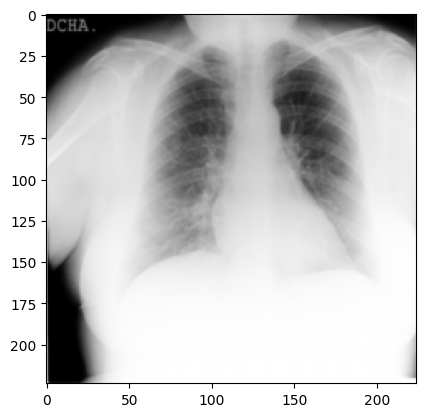

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


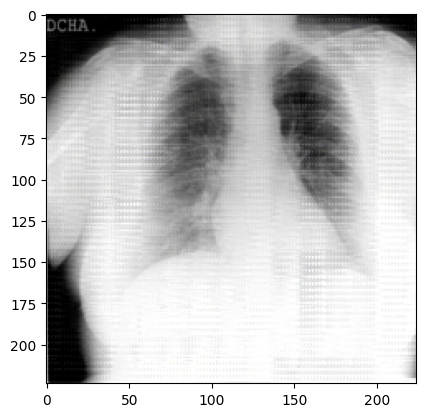

In [11]:
import matplotlib.pyplot as plt
plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy().astype(int))
plt.show()

plt.imshow((image + v).cpu().squeeze().permute(1, 2, 0).numpy().astype(int))
plt.show()